## Basic CML data processing - From raw signals to rain rates
___
<img src="https://wires.onlinelibrary.wiley.com/cms/asset/e241f352-21c4-49e7-a8f7-ecf6ff15686f/wat21337-fig-0001-m.jpg" alt="drawing" width="1300"/>

<img src="https://hess.copernicus.org/articles/24/2931/2020/hess-24-2931-2020-f03-web.png" alt="drawing" width="1000"/>

## 1. Loading and selecting CML data

**Goal**: Open CML data stored as Netcdf as an `xarray.Dataset` object and select one CMLs data

### 1.0 Import packages and adjust settings

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import xarray as xr

import pycomlink as pycml

import matplotlib.pyplot as plt

import numpy as np

In [2]:
data_path = pycml.io.examples.get_example_data_path()  # get path to example data
print(data_path)

/home/erlend/Documents/GitHub/pycomlink/pycomlink/io/example_data


In [3]:
xr.set_options(display_style='html'); # Show xarray.Dataset representation as text

### 1.1 Open dataset from netcdf

In [4]:
# open NetCDF as xarray.Dataset
cmls = xr.open_dataset(data_path + '/example_cml_data.nc') 
cmls

<xarray.Dataset>
Dimensions:           (time: 15840, cml_id: 500, channel_id: 2)
Coordinates:
  * time              (time) datetime64[ns] 2018-05-10 ... 2018-05-20T23:59:00
  * cml_id            (cml_id) object '0' '1' '2' '3' ... '497' '498' '499'
    length            (cml_id) float64 ...
    site_a_latitude   (cml_id) float64 ...
    site_a_longitude  (cml_id) float64 ...
    site_b_latitude   (cml_id) float64 ...
    site_b_longitude  (cml_id) float64 ...
  * channel_id        (channel_id) object 'channel_1' 'channel_2'
    frequency         (cml_id, channel_id) float64 ...
    polarization      (cml_id, channel_id) object ...
Data variables:
    rsl               (channel_id, cml_id, time) float32 ...
    tsl               (channel_id, cml_id, time) float32 ...

In [5]:
# size of dataset, this dataset is currently not loaded to memory
print(cmls.nbytes/1e6, ' MB')

126.886736  MB


### 1.2 Select CML and channel coordinates

In [6]:
# select cml with index 50, two channels, this loads the data to memory (sometimes you need to do it manually)
cml = cmls.isel(cml_id = 0, channel_id = 0) 
cml

<xarray.Dataset>
Dimensions:           (time: 15840)
Coordinates:
  * time              (time) datetime64[ns] 2018-05-10 ... 2018-05-20T23:59:00
    cml_id            <U1 '0'
    length            float64 6.179
    site_a_latitude   float64 58.26
    site_a_longitude  float64 1.388
    site_b_latitude   float64 58.25
    site_b_longitude  float64 1.304
    channel_id        <U9 'channel_1'
    frequency         float64 2.491e+10
    polarization      object 'V'
Data variables:
    rsl               (time) float32 -47.0 -47.0 -46.7 ... -47.0 -46.7 -46.7
    tsl               (time) float32 13.0 12.0 12.0 12.0 ... 12.0 12.0 12.0 12.0

In [7]:
print(cml.nbytes/1e6, ' MB')

0.253536  MB


**&#8594;** the size of the data is reduced significantly

### 1.3 Select time range

In [8]:
cml.rsl.time

<xarray.DataArray 'time' (time: 15840)>
array(['2018-05-10T00:00:00.000000000', '2018-05-10T00:01:00.000000000',
       '2018-05-10T00:02:00.000000000', ..., '2018-05-20T23:57:00.000000000',
       '2018-05-20T23:58:00.000000000', '2018-05-20T23:59:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time              (time) datetime64[ns] 2018-05-10 ... 2018-05-20T23:59:00
    cml_id            <U1 '0'
    length            float64 6.179
    site_a_latitude   float64 58.26
    site_a_longitude  float64 1.388
    site_b_latitude   float64 58.25
    site_b_longitude  float64 1.304
    channel_id        <U9 'channel_1'
    frequency         float64 2.491e+10
    polarization      object 'V'

In [9]:
# select date range
cml = cml.sel(time=slice('2018-05-11','2018-05-20T23:00')) 
cml

<xarray.Dataset>
Dimensions:           (time: 14341)
Coordinates:
  * time              (time) datetime64[ns] 2018-05-11 ... 2018-05-20T23:00:00
    cml_id            <U1 '0'
    length            float64 6.179
    site_a_latitude   float64 58.26
    site_a_longitude  float64 1.388
    site_b_latitude   float64 58.25
    site_b_longitude  float64 1.304
    channel_id        <U9 'channel_1'
    frequency         float64 2.491e+10
    polarization      object 'V'
Data variables:
    rsl               (time) float32 -46.7 -46.7 -46.7 ... -46.7 -47.0 -46.7
    tsl               (time) float32 12.0 12.0 12.0 12.0 ... 12.0 12.0 13.0 12.0

**&#8594;** New start and end time displayed in the `time` coordinate

## 2. Transmitted and received signal levels

**Goal**: Inspect CML data variables by plotting them, remove outliers and compute the transmitted minus received signal level (**tl**)

### 2.1 Plot the transmitted signal level (TSL) series

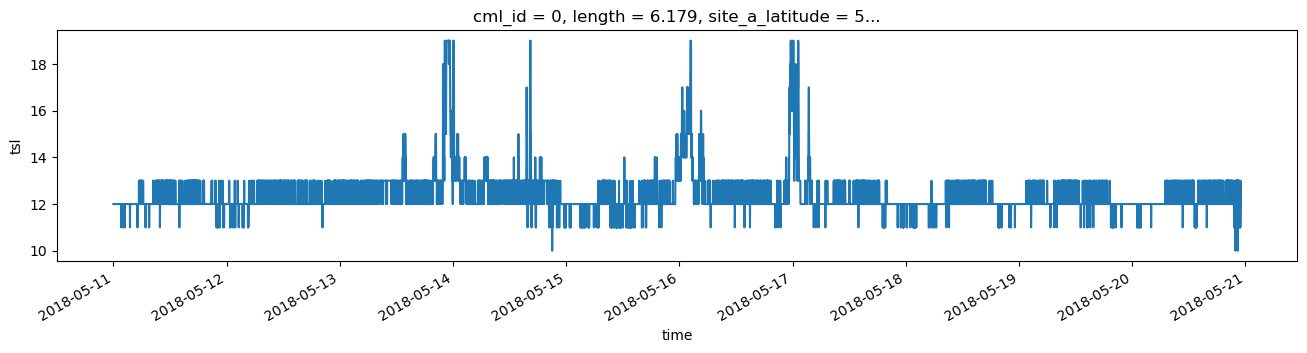

In [10]:
cml.tsl.plot.line(x='time', figsize=(16,3));
# Access 'tsl' variable using `.tsl`
# Use xarrays builtin plotting functionality for line plots. 
# Select 'time' as the x coordinate. By default, the variable will be on the y-axis

### 2.2 Plot the received signal level (RSL) series and remove outliers

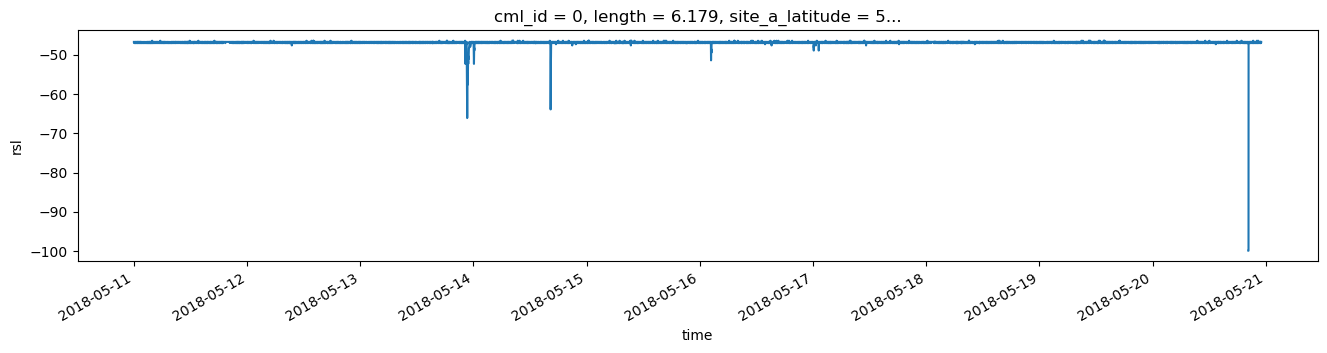

In [11]:
cml.rsl.plot.line(x='time', figsize=(16,3));

 * rsl value of -99 is an outlier (some error happend at this time-step)
 
&#8594; replace such default values by NaN (Not a Number)

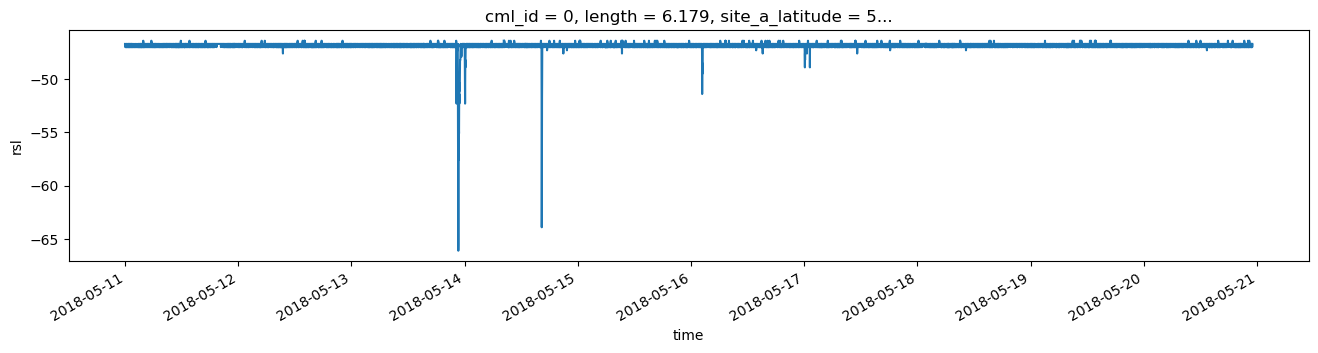

In [12]:
# 2.2 Remove outliers 
# Some datasets stores signal levels as multiplies of integers, instead of floats. This reduces dataset size.
# In the OpenMRG dataset data is stored as floats and missing values is stored as floats
cml['tsl'] = cml.tsl.where(cml.tsl != 255.0) # TSL outliers, show tooltip using shift+tab
cml['rsl'] = cml.rsl.where(cml.rsl != -99.9) # RSL outliers
cml.rsl.plot.line(x='time', figsize=(16,3)); # plot again to see result

# note outliers in OpenMRG has already been replaced by nan

### 2.3: Compute the transmitted minus received signal level (tl) series

&#8594; **tl** represents the **total path loss** along the CML

In [13]:
cml['tl'] = cml.tsl - cml.rsl

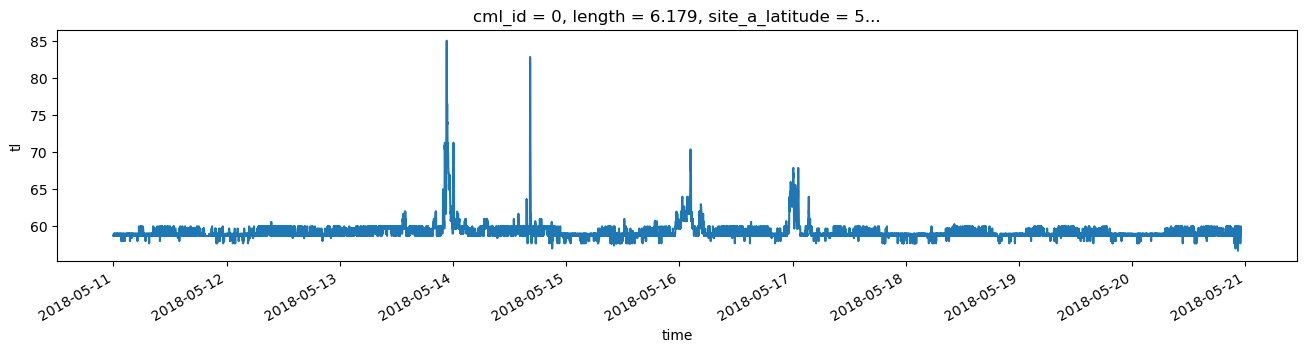

In [14]:
cml.tl.plot.line(x='time', figsize=(16,3));

### 3. Wet/dry detection

**Goal**: Find the rainy periods in the time-series

Rainfall generates high tl values for short periods
    
&#8594; How can we detect such periods? 

&#8594; We will use a rolling standard deviation (RSD) as suggested by [Schleiß et al. 2010](https://ieeexplore.ieee.org/document/5438724).



<img src="https://hess.copernicus.org/articles/24/2931/2020/hess-24-2931-2020-f03-web.png" alt="drawing" width="1000"/>

### 3.1: Compute a rolling window standard deviation

In [15]:
cml['rsd'] = cml.tl.rolling(time=60, center=True).std()

 * use `xarray.DataArray.rolling()` to create a rolling window of length 60 timesteps (60 minutes)
 
 * `.rolling(center=True).std()` writes the windows standard deviation to the central time step

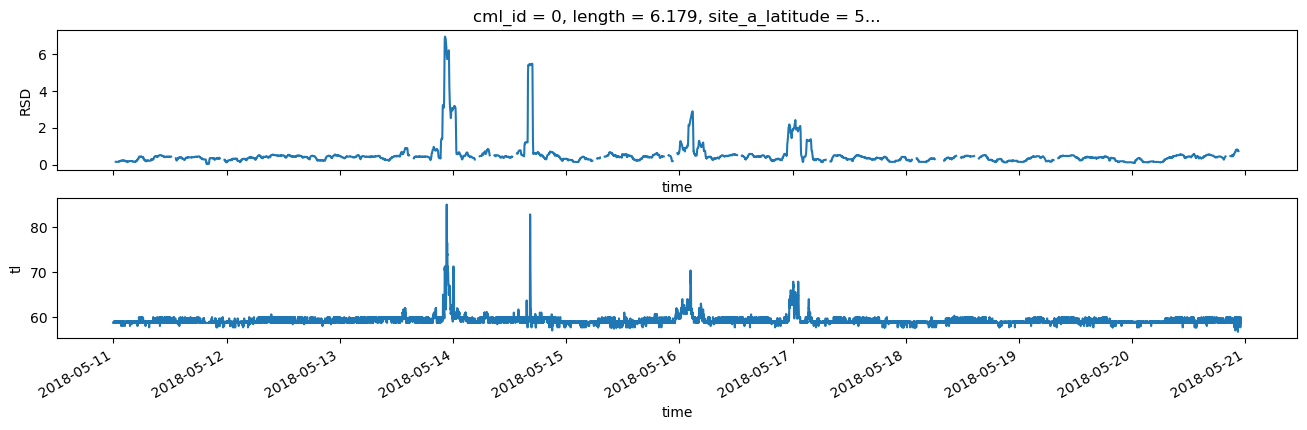

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(16,4), sharex=True)
cml.rsd.plot.line(x='time', ax=axs[0])
cml.tl.plot.line(x='time', ax=axs[1])
axs[0].set_ylabel('RSD')
axs[1].set_ylabel('tl')
axs[1].set_title('');

### 3.2: Perform basic wet-dry classification

In [17]:
threshold = 0.8
cml['wet'] = cml.rsd > threshold

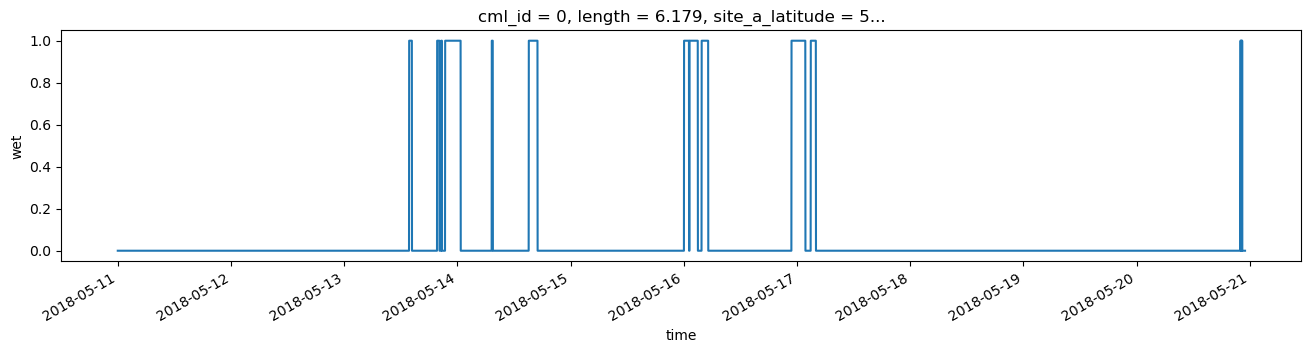

In [18]:
cml['wet'].plot.line(x='time', figsize=(16,3));

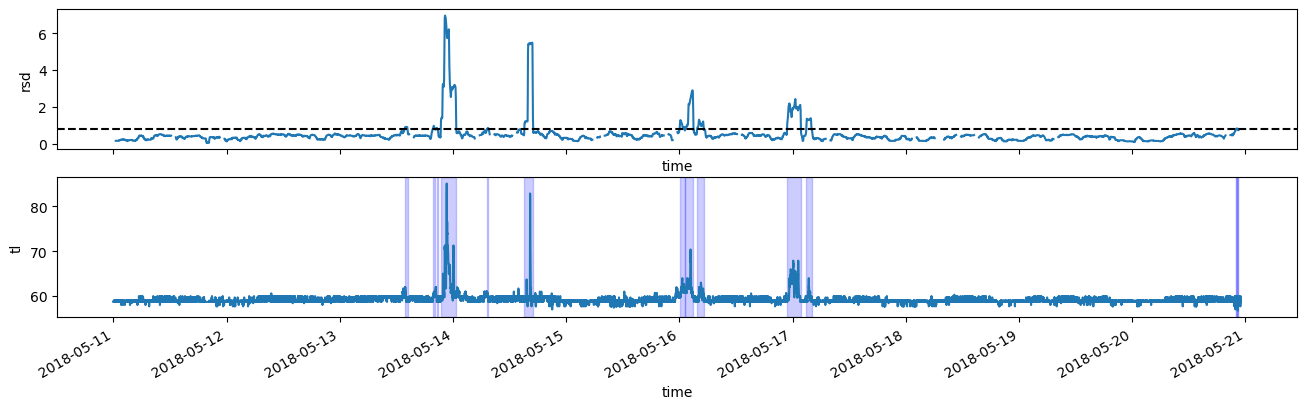

In [19]:
# 3.2
fig, axs = plt.subplots(2, 1, figsize=(16,4), sharex=True)
cml.rsd.plot.line(x='time', ax=axs[0])
axs[0].axhline(threshold, color='k', linestyle='--', label='threshold')
cml.tl.plot.line(x='time', ax=axs[1]);

# Get start and end of dry event
wet_start = np.roll(cml.wet, -1) & ~cml.wet
wet_end = np.roll(cml.wet, 1) & ~cml.wet
# Plot shaded area for each wet event
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    axs[1].axvspan(cml.time.values[wet_start_i], cml.time.values[wet_end_i], color='b', alpha=0.2)
axs[0].set_title('');
axs[1].set_title('');

This is the most basic way of doing a wet-dry classification. The crucial part here is to find the optimal threshold. We used a standard value of 0.8 which is more or less suitable for most CML time series. To get the good performance for CML rainfall estimation this threshold should be adapted to the noisiness of the individual CML time series, e.g. as in [Graf et al. 2020](https://hess.copernicus.org/articles/24/2931/2020/hess-24-2931-2020.html).

# Exercises

### Exercise 1 (From Netcdf to wet dry detection)

 1.1 Write a minimal working code example to compute the variable `wet` starting from the NetCDF file.
 
 1.2. Compute `wet` for a different CML with the unique cml_id `67`. 
 - (Hint: You can also use `.sel()` instead of `.isel()` to select by link name. In this particular exercise the link names is just their indice.)
    
 1.3. Use different thresholds for the rolling standard deviation (e.g. 0.1, 1 and 10) to compute `wet`. How do the results differ?

### Exercise 2 (CML data from Sweden)

 1. Repeat exercise 1.1 with CML data from OpenMRG
    * (Hint: Use the provided NetCDF file `./OPENSENSE_training_school_2023/data/cml/openMRG_example.nc`, select the CML number 50 in the dataset, compute `wet` and plot `tl` and `wet` in separate plots.)
    * openMRG uses OpenSense naming conventions for the coordinate names, so they can differ slightly from the current pycomlink example

### Exercise 3 (optional)
Plot the number of rain events as a function of the standard deviation `threshold`.

### Exercise 1.1 (From Netcdf to wet dry detection)

 1. Write a minimal working code example to compute the variable `wet` starting from the NetCDF file and plot the tl and the wet variables in separate subplots.

In [20]:
# Write code here:

**Caution:** Running the following cell will load the hints!

In [ ]:
if input("Enter 'Hint' to display the hints: ")=='Hint':
    %load hints_solutions/1_1_hint.py

**Caution:** Running the following cell will load the solution!

In [ ]:
if input("Enter 'Solution' to display solutions: ")=='Solution':
    %load hints_solutions/1_1_solution.py

### Exercise 1.2 (From Netcdf to wet dry detection)

 2. Compute `wet` for a different CML with the unique cml_id `67`. 
- (Hint: You can also use `.sel()` instead of `.isel()` to select by link name. In this particular exercise the link names is just their indice.)

In [ ]:
# Write code here:


**Caution:** The following cell will load the solution!

In [ ]:
if input("Enter 'Solution' to display solutions: ")=='Solution':
    %load hints_solutions/1_2_solution.py

### Exercise 1.3 (From Netcdf to wet dry detection)
 3. Use different thresholds for the rolling standard deviation (e.g. 0.1, 1 and 10) to compute `wet`.

In [ ]:
# Write code here:


**Caution:** The following cell will load the solution!

In [ ]:
if input("Enter 'Solution' to display solutions: ")=='Solution':
    %load hints_solutions/1_3_solution.py

### Exercise 2 (CML data from Gothenburg - OpenMRG)

Repeat exercise 1.1 with CML data from Gothenburg Sweeden, the OpenMRG dataset. Use the provided NetCDF file `path/to/file`, select the first CML in the dataset, compute `wet` and plot `tl` and `wet` in separate plots. 

In [ ]:
# Write code here:


**Caution:** The following cell will load the solution!

In [ ]:
if input("Enter 'Solution' to display solutions: ")=='Solution':
    %load hints_solutions/1_2_1_solution.py

### Exercise 3 (optional)

Plot the number of rain events as a function of the standard deviation `threshold`

In [ ]:
# Write code here:


## What happened so far:

In [26]:
cml = (xr.open_dataset('../data/cml/openMRG_example.nc') #<------- see 1.1
       .isel(sublink_id = 0, cml_id = 50) #<---------------------- see 1.2
       .sel(time=slice('2015-08-27','2015-08-28')).load()) #<----- see 1.3 and 1.4

cml['tsl'] = cml.tsl.where(cml.tsl != 255.0) #<------------------- see 2.2 (not needed for the OpenMRG data)
cml['rsl'] = cml.rsl.where(cml.rsl != -99.9) #<------------------- see 2.2
cml['tl'] = cml.tsl - cml.rsl #<-------------------------------- see 2.3

cml['rsd'] = cml.tl.rolling(time=60, center=True).std() #<----- see 3.1
cml['wet'] = cml.rsd > 0.6 #<------------------------------------ see 3.2


## 4. Compensation of wet antenna attenuation

**Goal**: Rain drops on the antenna cover can create additional attenuation that we need to subtract before estimating the path averaged rainfall rate.

### 4.1 Estimate constant baseline

In [27]:
cml['baseline'] = pycml.processing.baseline.baseline_constant(trsl=cml.tl, wet=cml.wet, n_average_last_dry=5)

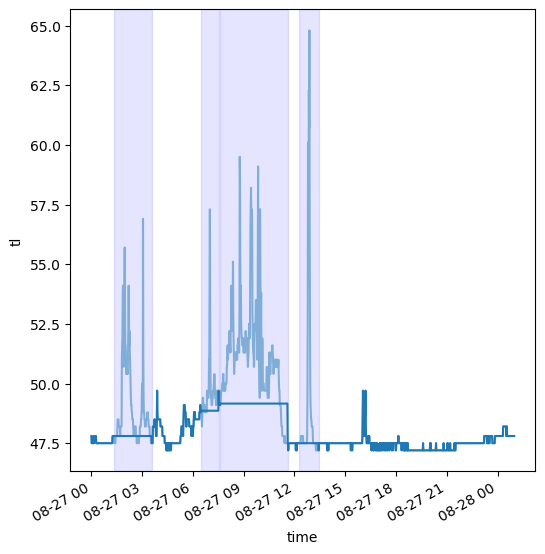

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

cml.tl.sel(time=slice('2015-08-27','2015-08-28')).plot.line(x='time', alpha=0.5, ax=ax)
plt.gca().set_prop_cycle(None)
cml.baseline.sel(time=slice('2015-08-27','2015-08-28')).plot.line(x='time', ax=ax);
plt.gca().set_prop_cycle(None)
ax.set_ylabel('tl');

# Get start and end of dry event
wet_start = np.roll(cml.wet, -1) & ~cml.wet
wet_end = np.roll(cml.wet, 1) & ~cml.wet
# Plot shaded area for each wet event
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    ax.axvspan(cml.time.values[wet_start_i], cml.time.values[wet_end_i], color='b', alpha=0.1)
ax.set_title('');


### 4.2 Perform wet antenna estimation

In [29]:
cml['waa'] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=cml.tl, 
    baseline=cml.baseline, 
    wet=cml.wet, 
    waa_max=2.2, 
    delta_t=1, 
    tau=15,
)

In [30]:
cml['A'] = cml.tl - cml.baseline - cml.waa # subtract baseline and wet antenna attenuation from total path loss
cml['A'] = cml.A.where(cml.A > 0, 0) # set negative values to zero

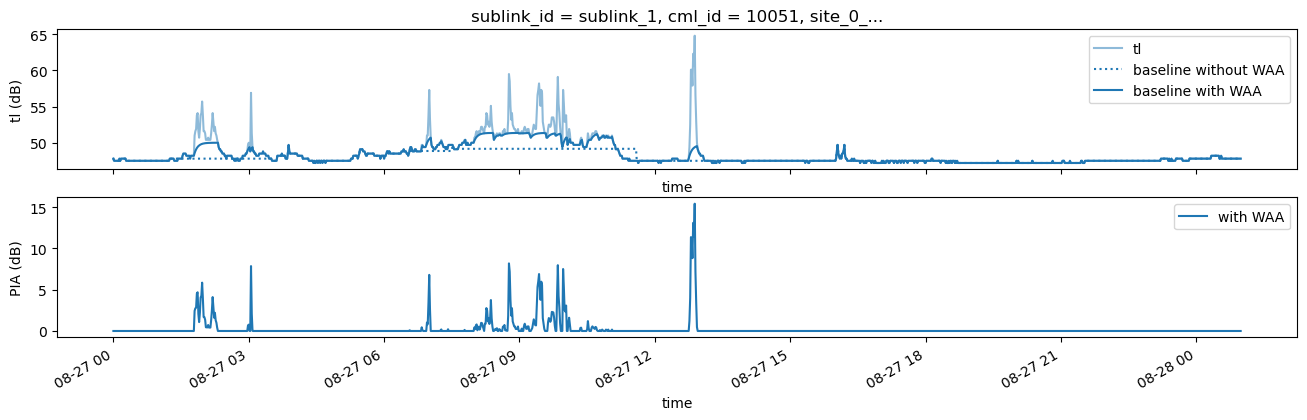

In [31]:
fig, axs = plt.subplots(2, 1, figsize=(16,4), sharex=True)
cml.tl.plot.line(x='time', alpha=0.5, color='tab:blue', label='tl', ax=axs[0])
cml.baseline.plot.line(
    x='time', 
    linestyle=':', 
    color='tab:blue', 
    label='baseline without WAA', 
    ax=axs[0]
)
(cml.baseline + cml.waa).plot.line(
    x='time', 
    color='tab:blue', 
    label='baseline with WAA', 
    ax=axs[0]
)
cml.A.plot.line(x='time', color='tab:blue', label='with WAA', ax=axs[1])
axs[0].set_ylabel('tl (dB)')
axs[1].set_ylabel('PIA (dB)')
axs[1].set_title('')
axs[1].legend()
axs[0].legend();

### 4.3 Compare to uncorrected baseline 

In [50]:
t_start = '2015-08-27T00'
t_end = '2015-08-27T15'

In [51]:
cml['A_no_waa_correct'] = cml.tl - cml.baseline
cml['A_no_waa_correct'] = cml.A_no_waa_correct.where(cml.A_no_waa_correct > 0, 0)

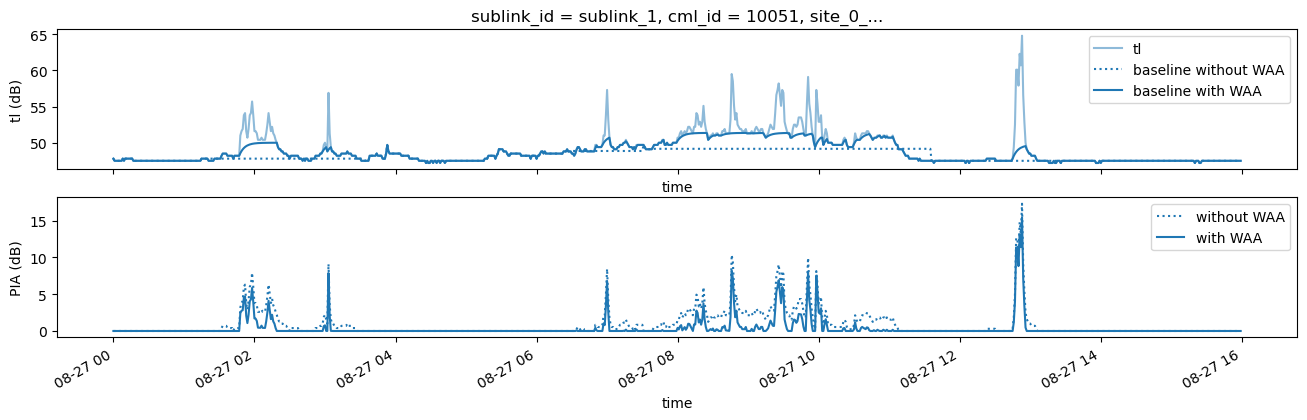

In [52]:
fig, axs = plt.subplots(2, 1, figsize=(16,4), sharex=True)
cml.tl.sel(time=slice(t_start,t_end)).plot.line(x='time', alpha=0.5, color='tab:blue', label='tl', ax=axs[0])
cml.baseline.sel(time=slice(t_start,t_end)).plot.line(x='time', linestyle=':', color='tab:blue', label='baseline without WAA', ax=axs[0])
(cml.baseline + cml.waa).sel(time=slice(t_start,t_end)).plot.line(x='time', color='tab:blue', label='baseline with WAA', ax=axs[0])
cml.A_no_waa_correct.sel(time=slice(t_start,t_end)).plot.line(x='time', linestyle=':', color='tab:blue', label='without WAA', ax=axs[1])
cml.A.sel(time=slice(t_start,t_end)).plot.line(x='time', color='tab:blue', label='with WAA', ax=axs[1])
axs[0].set_ylabel('tl (dB)')
axs[1].set_ylabel('PIA (dB)')
axs[1].set_title('')
axs[0].legend()
axs[1].legend();

## 5 Calculate rain rate

<img src="https://wires.onlinelibrary.wiley.com/cms/asset/0bbeb412-fe72-4d18-b201-f6dadefe60bc/wat21337-fig-0003-m.jpg" alt="drawing" width="1000"/>

**Goal**: Use the k-R relation to transform attenuation into rain rate. The relation depends on the CML frequency.

### 5.1 Compute path averaged rain rate

In [53]:
cml['R'] = pycml.processing.k_R_relation.calc_R_from_A(
    A=cml.A, 
    L_km=float(cml.length)/1000, 
    f_GHz=cml.frequency/1000,
    pol=cml.polarization
)

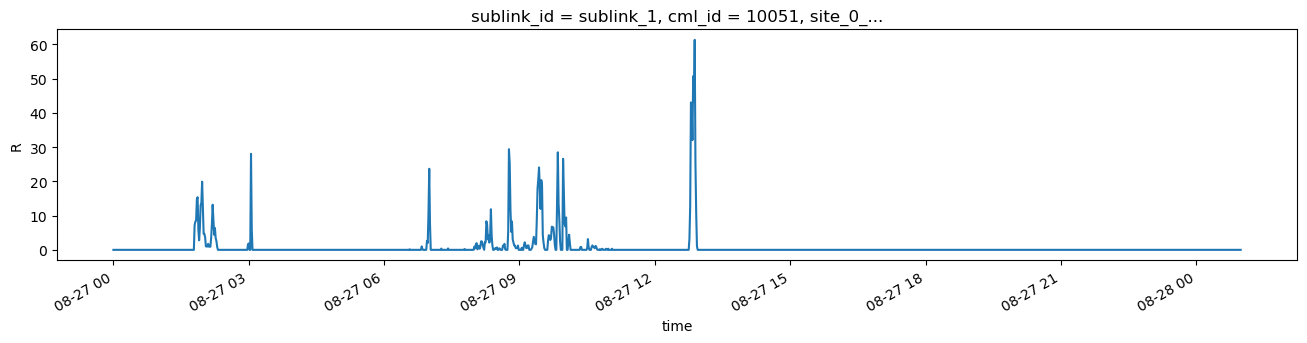

In [54]:
fig, ax = plt.subplots(figsize=(16,3))
cml.R.plot.line(x='time');

# Exercises:

### Exercise 4:
Compute the rainrate for link 50 in the OpenMRG dataset for all timesteps. 

In [ ]:
# Code: 

### Exercise 5:
Copute the rainrate for link 50, but set frequency equal to 20 GHz instead. How much to the estimates differ and what implications does this have for CML rainfall estimation? 

In [ ]:
# Code: 

### Exercise 6:
How dows the RSD threshold for wet dry detection affect the estimated rainfall ammounts? 

In [ ]:
# Code: 